In this notebook we use the prime basis given in Wheeler-Xue-Yotov 2011 paper, (Eq 2.18). Note that the dimension of the prime basis is 18 and we don't need to apply any constraint to reduce the dimension. The only change we did here is that we defined $P_1^3(E)$ on the physical element $E$ and mapped the 6 enrichments to $E$ by Piola transformation.

In [1]:
using Plots
using LinearAlgebra
using Jacobi
using Test

The prism is defined by cutting a cube $[-1,1]^3$ on diagonal $y=-x$

In [2]:
function TrilinearMap(coord_E, xhat, yhat, zhat)
    """
    Input:
    coord_E: coordinate of element E as a 6x3 matrix
    The prism is defined by cutting a cube [-1,1]^3 on diagonal y = -x
    
    Local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    
    m = length(xhat)
    N1 = @. 0.25*(-xhat-yhat)*(1-zhat)
    N2 = @. 0.25*(1+xhat)*(1-zhat)
    N3 = @. 0.25*(1+yhat)*(1-zhat)
    N4 = @. 0.25*(-xhat-yhat)*(1+zhat)
    N5 = @. 0.25*(1+xhat)*(1+zhat)
    N6 = @. 0.25*(1+yhat)*(1+zhat)
    N = [N1 N2 N3 N4 N5 N6]
    X = N * coord_E
    # X(3,m), 1st row x, 2nd row y, 3rd row z
    X = X'
    # gradient of N, [dN/dxhat; dN/dyhat; dN/dzhat]
    GradN = zeros(3,m,6)
    GradN[1,:,:] = @. 0.25*[-(1-zhat) (1-zhat) zeros(m) -(1+zhat) (1+zhat) zeros(m)]
    GradN[2,:,:] = @. 0.25*[-(1-zhat) zeros(m) (1-zhat) -(1+zhat) zeros(m) (1+zhat)]
    GradN[3,:,:] = @. 0.25*[-(-xhat-yhat) -(1+xhat) -(1+yhat) (-xhat-yhat) (1+xhat) (1+yhat)]

    # JT = [[dx/dxhat, dy/dxhat, dz/dxhat],
    #       [dx/dyhat, dy/dyhat, dz/dyhat],
    #       [dx/dzhat, dy/dzhat, dz/dzhat]] (3m x 3)

    JTxhat = GradN[1,:,:] * coord_E
    dxdxhat = JTxhat[:,1]
    dydxhat = JTxhat[:,2]
    dzdxhat = JTxhat[:,3]
    JTyhat = GradN[2,:,:] * coord_E
    dxdyhat = JTyhat[:,1]
    dydyhat = JTyhat[:,2]
    dzdyhat = JTyhat[:,3]
    JTzhat = GradN[3,:,:] * coord_E
    dxdzhat = JTzhat[:,1]
    dydzhat = JTzhat[:,2]
    dzdzhat = JTzhat[:,3]
    # compute det
    j1 = @. (dxdxhat*dydyhat*dzdzhat + dxdyhat*dydzhat*dzdzhat + dxdzhat*dydxhat*dzdyhat)
    j2 = @. (dxdxhat*dydzhat*dzdyhat + dxdyhat*dydxhat*dzdzhat + dxdzhat*dydyhat*dzdxhat)
    detJ = @. j1 - j2
    
    J = zeros(3,m,3)
    J[1,:,:] = [dxdxhat dxdyhat dxdzhat]
    J[2,:,:] = [dydxhat dydyhat dydzhat]
    J[3,:,:] = [dzdxhat dzdyhat dzdzhat]
    
    return X, J, detJ
end

TrilinearMap (generic function with 1 method)

In [3]:
function PrimeBasis(coord_E, xhat, yhat, zhat)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    
    Return:
    Prime basis: of size (3,m,18) evaluated on xhat,yhat,zhat
    Note the first entries "3", are prime basis in the directions x,y,z
    "m" are the length of xhat,yhat, zhat
    "18" is the dimension of the prime basis
    """
    m = length(xhat)
    # supplements from Wheeler, Xue, & Yotov, 2011
    shat1 = [(2*yhat .* zhat) (zeros(m)) (zeros(m))]
    shat2 = [(zeros(m)) (2*xhat .* zhat) (zeros(m))]
    shat3 = [(zeros(m)) (2*yhat .* zhat) (-zhat.^2)]  
    shat4 = [(2*xhat .* zhat) (zeros(m)) (-zhat.^2)]
    shat5 = [(xhat.^2) (xhat .* yhat) (-3*xhat .* zhat)]
    shat6 = [(yhat .* xhat) (yhat.^2) (-3*yhat .* zhat)]

    # X are in E
    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)
    x = X[1,:]
    y = X[2,:]
    z = X[3,:]
    
    # we have 18 basis
    # the first 12 is defined on E using x,y,z
    P = zeros(3,m,18)
    P[1,:,1] = ones(m)
    P[1,:,2] = x
    P[1,:,3] = y
    P[1,:,4] = z
    P[2,:,5] = ones(m)
    P[2,:,6] = x
    P[2,:,7] = y
    P[2,:,8] = z
    P[3,:,9] = ones(m)
    P[3,:,10] = x
    P[3,:,11] = y
    P[3,:,12] = z
    
    # supplement are mapped to E by Piola
    P[1,:,13] = (J[1,:,1] .* shat1[:,1] + J[1,:,2] .* shat1[:,2] + J[1,:,3] .* shat1[:,3]) ./ detJ
    P[2,:,13] = (J[2,:,1] .* shat1[:,1] + J[2,:,2] .* shat1[:,2] + J[2,:,3] .* shat1[:,3]) ./ detJ
    P[3,:,13] = (J[3,:,1] .* shat1[:,1] + J[3,:,2] .* shat1[:,2] + J[3,:,3] .* shat1[:,3]) ./ detJ

    P[1,:,14] = (J[1,:,1] .* shat2[:,1] + J[1,:,2] .* shat2[:,2] + J[1,:,3] .* shat2[:,3]) ./ detJ
    P[2,:,14] = (J[2,:,1] .* shat2[:,1] + J[2,:,2] .* shat2[:,2] + J[2,:,3] .* shat2[:,3]) ./ detJ
    P[3,:,14] = (J[3,:,1] .* shat2[:,1] + J[3,:,2] .* shat2[:,2] + J[3,:,3] .* shat2[:,3]) ./ detJ

    P[1,:,15] = (J[1,:,1] .* shat3[:,1] + J[1,:,2] .* shat3[:,2] + J[1,:,3] .* shat3[:,3]) ./ detJ
    P[2,:,15] = (J[2,:,1] .* shat3[:,1] + J[2,:,2] .* shat3[:,2] + J[2,:,3] .* shat3[:,3]) ./ detJ
    P[3,:,15] = (J[3,:,1] .* shat3[:,1] + J[3,:,2] .* shat3[:,2] + J[3,:,3] .* shat3[:,3]) ./ detJ

    P[1,:,16] = (J[1,:,1] .* shat4[:,1] + J[1,:,2] .* shat4[:,2] + J[1,:,3] .* shat4[:,3]) ./ detJ
    P[2,:,16] = (J[2,:,1] .* shat4[:,1] + J[2,:,2] .* shat4[:,2] + J[2,:,3] .* shat4[:,3]) ./ detJ
    P[3,:,16] = (J[3,:,1] .* shat4[:,1] + J[3,:,2] .* shat4[:,2] + J[3,:,3] .* shat4[:,3]) ./ detJ

    P[1,:,17] = (J[1,:,1] .* shat5[:,1] + J[1,:,2] .* shat5[:,2] + J[1,:,3] .* shat5[:,3]) ./ detJ
    P[2,:,17] = (J[2,:,1] .* shat5[:,1] + J[2,:,2] .* shat5[:,2] + J[2,:,3] .* shat5[:,3]) ./ detJ
    P[3,:,17] = (J[3,:,1] .* shat5[:,1] + J[3,:,2] .* shat5[:,2] + J[3,:,3] .* shat5[:,3]) ./ detJ

    P[1,:,18] = (J[1,:,1] .* shat6[:,1] + J[1,:,2] .* shat6[:,2] + J[1,:,3] .* shat6[:,3]) ./ detJ
    P[2,:,18] = (J[2,:,1] .* shat6[:,1] + J[2,:,2] .* shat6[:,2] + J[2,:,3] .* shat6[:,3]) ./ detJ
    P[3,:,18] = (J[3,:,1] .* shat6[:,1] + J[3,:,2] .* shat6[:,2] + J[3,:,3] .* shat6[:,3]) ./ detJ
    
    return P
end

PrimeBasis (generic function with 1 method)

In [4]:
function GetNormal(coord_E, xhat, yhat, zhat, face)

    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat, yhat, zhat: are defined on the reference element Ehat
    and should be given as a vector (xhat=[1] or xhat =[1;1],...)
    face: that you want the normal
    Note the face and xhat, yhat, zhat should be consistent. See Normal test
    
    Return:
    n: of size(3,m)
    le: length of n
    """
    X, J, detJ = TrilinearMap(coord_E, xhat, yhat, zhat)

    dxdxhat = J[1,:,1]
    dxdyhat = J[1,:,2]
    dxdzhat = J[1,:,3]
    
    dydxhat = J[2,:,1]
    dydyhat = J[2,:,2]
    dydzhat = J[2,:,3]
    
    dzdxhat = J[3,:,1]
    dzdyhat = J[3,:,2]
    dzdzhat = J[3,:,3]

    m = length(xhat)
    
    if face == "left" && yhat == -ones(m)
        
        n1 = @. dydxhat*dzdzhat - dzdxhat*dydzhat
        n2 = @. dzdxhat*dxdzhat - dxdxhat*dzdzhat
        n3 = @. dxdxhat*dydzhat - dydxhat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
      
    elseif face == "back" && xhat == -ones(m)
        
        n1 = @. dzdyhat*dydzhat - dydyhat*dzdzhat 
        n2 = @. dxdyhat*dzdzhat - dzdyhat*dxdzhat
        n3 = @. dydyhat*dxdzhat - dxdyhat*dydzhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "diagonal" && xhat == -yhat
        #dxdshat = -dxdxhat + dxdyhat, ...
        dxdshat = J[1,:,2] - J[1,:,1]
        dydshat = J[2,:,2] - J[2,:,1]
        dzdshat = J[3,:,2] - J[3,:,1]
        
        n1 = @. dydshat*dzdzhat - dzdshat*dydzhat
        n2 = @. dzdshat*dxdzhat - dxdshat*dzdzhat
        n3 = @. dxdshat*dydzhat - dydshat*dxdzhat
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "top" && zhat == ones(m)
        
        n1 = @. dydxhat*dzdyhat - dzdxhat*dydyhat 
        n2 = @. dzdxhat*dxdyhat - dxdxhat*dzdyhat 
        n3 = @. dxdxhat*dydyhat - dydxhat*dxdyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    
    elseif face == "bottom" && zhat == -ones(m)
        
        n1 = @. dzdxhat*dydyhat - dydxhat*dzdyhat
        n2 = @. dxdxhat*dzdyhat - dzdxhat*dxdyhat
        n3 = @. dydxhat*dxdyhat - dxdxhat*dydyhat 
        leng = @. sqrt(n1*n1 + n2*n2 + n3*n3)
        n = zeros(3,m)
        n[1,:] = n1 ./ leng
        n[2,:] = n2 ./ leng
        n[3,:] = n3 ./ leng
    else
        error("face is not defined")
    end

    return n, leng
end

GetNormal (generic function with 1 method)

In [5]:
function PlotElem(coord_E)
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    
    Return:
    3D view and top view of the element
    """
    
    x = coord_E[:,1]
    y = coord_E[:,2]
    z = coord_E[:,3]
    nodes = [1 2 3 1 4 5 6 4]
    n = length(nodes)
    xx = zeros(n,1)
    yy = zeros(n,1)
    zz = zeros(n,1)
    for j =1:n
        xx[j] = x[nodes[j]] 
        yy[j] = y[nodes[j]] 
        zz[j] = z[nodes[j]]
    end
    plot(xx,yy,zz,color="black",legend=false)
    xx2 = zeros(2,1)
    yy2 = zeros(2,1)
    zz2 = zeros(2,1)
    xx2[1] = x[2]; xx2[2] = x[5]
    yy2[1] = y[2]; yy2[2] = y[5]
    zz2[1] = z[2]; zz2[2] = z[5]
    
    xx3 = zeros(2,1)
    yy3 = zeros(2,1)
    zz3 = zeros(2,1)
    xx3[1] = x[3]; xx3[2] = x[6]
    yy3[1] = y[3]; yy3[2] = y[6]
    zz3[1] = z[3]; zz3[2] = z[6]
    
    plot!(xx2,yy2,zz2,color="black",legend=false)
    p2 = plot!(xx3,yy3,zz3,color="black",legend=false, title = "3D view")
    
    # to see from top 
    # bottom face
    nodes = [1 2 3 1]
    n = length(nodes)
    xb = zeros(n,1)
    yb = zeros(n,1)
    for j =1:n
        xb[j] = x[nodes[j]] 
        yb[j] = y[nodes[j]] 
    end
    # top face
    nodes = [4 5 6 4]
    n = length(nodes)
    xt = zeros(n,1)
    yt = zeros(n,1)
    for j =1:n
        xt[j] = x[nodes[j]] 
        yt[j] = y[nodes[j]] 
    end
    plot(xb,yb,color="black",legend=false)
    pp=plot!(xt,yt,color="black",legend=false, title = "Top View")
    
    plot(p2,pp)
    
end

PlotElem (generic function with 1 method)

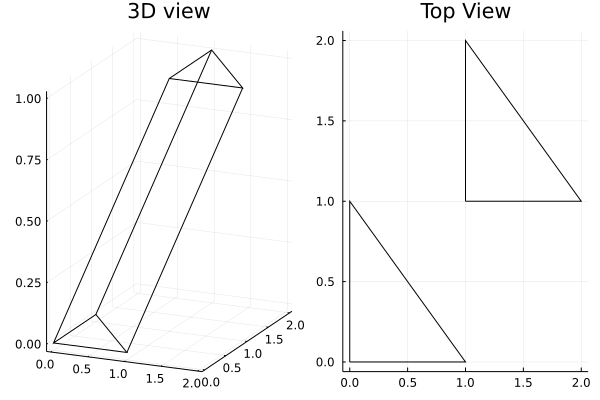

In [6]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1]
# reference element
#coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
PlotElem(coord_E)

# Test Normals
We test GetNormal function on above element. Since the face are planner, we can compute the normal at each face by cross product of edges on the face.

In [7]:
@testset "TestNormal" begin
    
    # unstructured element
     coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
    # reference element
    #coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
    
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")

    # check the left face normal
    a = coord_E[2,:] - coord_E[1,:] 
    b = coord_E[4,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nl[:] == c[:]

    # check the back face normal 
    a = coord_E[4,:] - coord_E[1,:]
    b = coord_E[3,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nbk[:] == c[:]
    
    # check the diagonal face normal 
    a = coord_E[3,:] - coord_E[2,:]
    b = coord_E[5,:] - coord_E[2,:]
    c = cross(a,b)
    c = normalize(c)
    @test nd[:] == c[:]
    
    # check the top face normal 
    a = coord_E[5,:] - coord_E[4,:]
    b = coord_E[6,:] - coord_E[4,:]
    c = cross(a,b)
    c = normalize(c)
    @test nt[:] == c[:]
    
    # check the bottom face normal 
    a = coord_E[3,:] - coord_E[1,:]
    b = coord_E[2,:] - coord_E[1,:]
    c = cross(a,b)
    c = normalize(c)
    @test nbt[:] == c[:]
    
end

Test Summary: | Pass  Total
TestNormal    |    5      5


Test.DefaultTestSet("TestNormal", Any[], 5, false, false)

In [8]:
include("GetQuadratureTriangle.jl") # returns w, q for integration over triangle (-1,-1), (1,-1), (-1,1)
#See test integration for example. Input is Q_tri which is the number of quadrature in 2D triangle.
# No.of Q_tri in 2D for above function can be: 1, 3, 4, 6, 7, 12, 13, 16, 19, 25 
# which is accurate for polynomial degree of : 1, 2, 3, 4, 5, 6,  7,  8,  9, 10

function GetQuadrature2D(Q)
    """
    Input:
    Q: number of quadrature points in 1D over [-1,1]
    
    Return:Gauss Quadrature over [-1,1]^2
    qx:
    qy:
    w2:
    """
    # 1D Gauss
    alpha = 0.0
    beta = 0.0
    q = zgj(Q, alpha, beta)
    w = wgj(q, alpha, beta)
    
    w2 = zeros(Q*Q)
    qx = zeros(Q*Q)
    qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            qx[k] = q[j]
            qy[k] = q[i]
            w2[k] = w[j]*w[i]
        end
    end
    return w2, qx, qy
end

function Legendre2D(x,y,i,j)
    # Legendre2D define on [-1,1]^2
    return legendre(x,i) .* legendre(y,j)
end

function Dubiner(x,y,i,j)
    # Dubiner polynomial defined on triangle (-1,-1),(1,-1),(-1,1)
    eta1 = 2*(1 .+ x) ./ clamp.(1 .- y,1e-12,10) .- 1
    eta2 = y
    D    = jacobi.(eta1, i, 0, 0)
    D   *= (0.5*(1 .- eta2)) .^i
    D   *= jacobi.(eta2, j, 2*i+1, 0)
    return D
end


Dubiner (generic function with 1 method)

# Test Integration
We test our 2D quadrature integration over quad face and triangle face by checking the orthogonality of the Legendre and Dubiner polynomials over the face of above element we plotted it.

In [9]:
@testset "TestIntegration" begin

    # unstructured element
     coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
    # reference element
    #coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
   
    # get quadrature on [-1,1]^2
    Q1d_quad = 5 # No. pts in 1D
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # left face    
    n, le = GetNormal(coord_E, q1, m1, q2, "left")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # back face    
    n, le = GetNormal(coord_E, m1, q1, q2, "back")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # diagonal face    
    n, le = GetNormal(coord_E, -q1, q1, q2, "diagonal")
    Integral = (ww .* le)' *(Legendre2D.(q1,q2,2,0) .* Legendre2D.(q1,q2,1,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # get quadrature on (-1,-1), (1,-1), (-1,1)
    Q_tri = 16 # No. pts in 2D
    ww, q = GetQuadratureTriangle(Q_tri)
    q1 = q[:,1]
    q2 = q[:,2]
    m1 = -ones(Q_tri)
    p1 = ones(Q_tri)
    
    # top face    
    n, le = GetNormal(coord_E, q1, q2, p1, "top")
    Integral = (ww .* le)' *(Dubiner.(q1,q2,1,2) .* Dubiner.(q1,q2,2,2))
    @test isapprox(Integral, 0.;atol=1e-15)
    
    # bottom face    
    n, le = GetNormal(coord_E, q1, q2, m1, "bottom")
    Integral = (ww .* le)' *(Dubiner.(q1,q2,2,1) .* Dubiner.(q1,q2,2,2))
    @test isapprox(Integral, 0.;atol=1e-15)
end

Test Summary:   | Pass  Total
TestIntegration |    5      5


Test.DefaultTestSet("TestIntegration", Any[], 5, false, false)

In [10]:
function VondermondeMat(coord_E)
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    
    Return:
    VM of size(18,18)
    """
    # get the normals
    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    normals = [nbk nl nbt nd nl nbt nbk nd nbt nbk nl nt nd nl nt nbk nd nt]
    nd1 = [-1.;-1.;-1.]
    nd2 = [1.;-1.;-1.]
    nd3 = [-1.;1.;-1.]
    nd4 = [-1.;-1.;1.]
    nd5 = [1.;-1.;1.]
    nd6 = [-1.;1.;1.]
    # at each node we have 3 normals, thats why nd1,... is repeated 3 times
    nodes = [nd1 nd1 nd1 nd2 nd2 nd2 nd3 nd3 nd3 nd4 nd4 nd4 nd5 nd5 nd5 nd6 nd6 nd6]
    # vondermonde matrix, V_ij = phi_j(x_i).n_i
    VM = zeros(18,18)
    for i=1:18 # loop over dof
        for j=1:18 # loop over prime basis
            P = PrimeBasis(coord_E, nodes[1,i], nodes[2,i], nodes[3,i])
            VM[i,j] = P[1,1,j]*normals[1,i] + P[2,1,j]*normals[2,i] + P[3,1,j]*normals[3,i]
        end
    end

    return VM
end

VondermondeMat (generic function with 1 method)

In [11]:
function GetNodalBasis(coord_E, xhat, yhat, zhat)
   
    """
    Input:
    coord_E: coordinate of physical element E as a 6x3 matrix
    xhat,yhat,zhat (vector of size m): defined on reference element Ehat
    
    Return:
    Nhat of size(3,m,18): Nodal basis for prism
    """
    
    VM = VondermondeMat(coord_E)
    P = PrimeBasis(coord_E, xhat, yhat, zhat)
    invVM = inv(VM)
    
    m = length(xhat)
    Nhat = zeros(3,m,18)
    Nhat[1,:,:] = P[1,:,:] * invVM
    Nhat[2,:,:] = P[2,:,:] * invVM
    Nhat[3,:,:] = P[3,:,:] * invVM
    
    return Nhat
end

GetNodalBasis (generic function with 1 method)

In the following we compute 
$$
\int_{\partial E} \textbf{v}\cdot\textbf{n} \, L_i(s) L_j(t) dA
$$
where $L_i$ is Legendre polynomial in 1D, $s,t$ are the coordinate on a face, $\textbf{n}$ is the normal on the face $\partial E$ and $\textbf{v}$ is the nodal basis with dimension 18. So the output of the above integral is a vector of size 18.

In [12]:
function IntegrateNormalTrace(i,j,coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    i,j: degrees of Legendre polynomials L_i(s)L_j(t) or Dubiner_{i,j}
    coord_E: physical coordinate of element E
    face: face that you want to compute the normal component of the trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    a vector of size 18: which is the result of int{N.n * L_i(s)L_j(t)}dA

    local numbering of Prism
    
        4--------6           z
      / |                    |
    5   |                    |
    |   |                    /----y
    |   |                   /
    |   1 -------3         x
    | /
    2

    """
    # get quadrature on [-1,1]^2
    ww, q1, q2 = GetQuadrature2D(Q1d_quad)
    m1 = -ones(Q1d_quad*Q1d_quad)
    p1 = ones(Q1d_quad*Q1d_quad)
    
    # get quadrature on triangle (-1,-1), (1,-1), (-1,1)
    wwt, qt = GetQuadratureTriangle(Q_tri)
    q1t = qt[:,1]
    q2t = qt[:,2]
    m1t = -ones(Q_tri)
    p1t = ones(Q_tri)
    
    # left face includes nodes 1,2,4,5 at yhat = -1
    if face == "left"
        n, le = GetNormal(coord_E, q1, m1, q2, "left")
        N = GetNodalBasis(coord_E, q1, m1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # back face includes nodes 1,3,4,6 at xhat = -1
    elseif face == "back"
        n, le = GetNormal(coord_E, m1, q1, q2, face)
        N = GetNodalBasis(coord_E,m1, q1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))
        
    # diagonal face includes nodes 2,3,5,6 at xhat = -yhat
    elseif face == "diagonal"
        n, le = GetNormal(coord_E, -q1, q1, q2, face)
        N = GetNodalBasis(coord_E, -q1, q1, q2)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(ww .* le .* Legendre2D.(q1,q2,i,j))  
    
    # top face includes nodes 4,5,6 at zhat = 1
    elseif face == "top"
        n, le = GetNormal(coord_E, q1t, q2t, p1t, face)
        N = GetNodalBasis(coord_E,q1t, q2t, p1t)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
        
    # bottom face includes nodes 1,2,3 at zhat = -1
    elseif face == "bottom"
        n, le = GetNormal(coord_E, q1t, q2t, m1t, face)
        N = GetNodalBasis(coord_E,q1t, q2t, m1t)
        Ndotn = N[1,:,:] .* n[1,:] + N[2,:,:] .* n[2,:] + N[3,:,:] .* n[3,:]
        trace = Ndotn' *(wwt .* le .* Dubiner.(q1t,q2t,i,j))
    else
        error("face is not defined")
    end
    
    return trace
    
end

IntegrateNormalTrace (generic function with 1 method)

In [13]:
function NormalTrace(coord_E, face, Q1d_quad, Q_tri)
    """
    Input:
    coord_E: physical coordinate of element E
    face: face that you want the normal trace
    Q1d_quad: No. pts in 1D for integration over quad faces
    Q_tri: No. pts in 2D for integration over triangle faces
    
    Return:
    Computed normal trace for all faces with different (i,j)
    """
    
    # On each quad face we compute trace_i,j
    # for (i,j) = (2,0),(2,1),(2,2),(1,2),(0,2) 
    # On triangle face we have above (i,j)+(1,1)
    
    n = [2 2 2 1 0]
    N = length(n)
    
    if face == "top" || face == "bottom"
        # 6 constraint, 18 dim
        L = zeros(N+1,18)
        for j = 1:N # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
        L[N+1,:] = IntegrateNormalTrace(1, 1, coord_E, face, Q1d_quad, Q_tri)
    else
        # 5 constraint, 18 dim
        L = zeros(N,18)
        for j = 1:length(n) # loop over legendre_i,j
            trace = IntegrateNormalTrace(n[j], n[N+1-j], coord_E, face, Q1d_quad, Q_tri)
            L[j,:] = trace
        end
    end
    
    return L
end

NormalTrace (generic function with 1 method)

# Test Normal Trace
We check the normal component of the trace in the following for plotted element above. The output of the NormalTrace function which is the matrix of size (5,18) for quad faces and (6,18) for triangle faces must be zero.

In [14]:
function TestNormalTrace(coord_E)

@testset "TestNormalTrace" begin
    
    err = 1e-14
    Q1d_quad = 5
    Q_tri = 19
    trace = NormalTrace(coord_E, "left", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "back", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "diagonal", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "top", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
    trace = NormalTrace(coord_E, "bottom", Q1d_quad, Q_tri)
    # check if they are zero
    for i = 1:size(trace,1)
        for j = 1:size(trace,2)
            @test isapprox(trace[i,j], 0.;atol=err)
        end
    end
    
end
    return
end

TestNormalTrace (generic function with 1 method)

In [15]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.]
# reference element
#coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
TestNormalTrace(coord_E)

Test Summary:   | Pass  Total
TestNormalTrace |  486    486


# Test Nodal Basis Value
In the following we check $\textbf{v}\cdot\textbf{n}$. At each node we compute this dot product, the result must be 1 and on the other nodes it must be 0.

In [16]:
function TestNodalBasisValue(coord_E)

@testset "TestNodalBasisValue" begin

    nl, le = GetNormal(coord_E, [0.], [-1.],[0.],"left")
    nd, le = GetNormal(coord_E, [0.], [0.],[0.],"diagonal")
    nbt, le = GetNormal(coord_E, [-0.5], [-0.5],[-1.],"bottom")
    nt, le = GetNormal(coord_E, [-0.5], [-0.5],[1.],"top")
    nbk, le = GetNormal(coord_E, [-1.], [0.],[0.],"back")
    
    err = 1e-14
    #============= Node 1, coordinate (-1,-1,-1)==============#
    Nhat = GetNodalBasis(coord_E,[-1.], [-1.], [-1])
        
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 1.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 2, coordinate (1,-1,-1)==============#
    Nhat = GetNodalBasis(coord_E,[1.], [-1.], [-1])
    
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 1.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 3, coordinate (-1,1,-1)==============#
    Nhat = GetNodalBasis(coord_E,[-1.], [1.], [-1])
    
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 1.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 4, coordinate (-1,-1,1)==============#
    Nhat = GetNodalBasis(coord_E,[-1.], [-1.], [1])
    
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 1.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 5, coordinate (1,-1,1)==============#
    Nhat = GetNodalBasis(coord_E,[1.], [-1.], [1])
    
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 1.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 0.;atol=err)
    
    #============= Node 6, coordinate (-1,1,1)==============#
    Nhat = GetNodalBasis(coord_E,[-1.], [1.], [1])
    
    # check node 1
    @test isapprox(dot(Nhat[:,1,1],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,2],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,3],nbt), 0.;atol=err)
    # check node 2
    @test isapprox(dot(Nhat[:,1,4],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,5],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,6],nbt), 0.;atol=err)
    # check node 3
    @test isapprox(dot(Nhat[:,1,7],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,8],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,9],nbt), 0.;atol=err)
    # check node 4
    @test isapprox(dot(Nhat[:,1,10],nbk), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,11],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,12],nt), 0.;atol=err)
    # check node 5
    @test isapprox(dot(Nhat[:,1,13],nd), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,14],nl), 0.;atol=err)
    @test isapprox(dot(Nhat[:,1,15],nt), 0.;atol=err)
    # check node 6
    @test isapprox(dot(Nhat[:,1,16],nbk), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,17],nd), 1.;atol=err)
    @test isapprox(dot(Nhat[:,1,18],nt), 1.;atol=err)
    
end
    
    return
end

TestNodalBasisValue (generic function with 1 method)

In [17]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1]
# reference element
#coord_E = [-1. -1. -1.;1. -1. -1.;-1. 1. -1.;-1. -1. 1.;1. -1. 1.;-1. 1. 1.]
TestNodalBasisValue(coord_E)

Test Summary:       | Pass  Total
TestNodalBasisValue |  108    108


# For the following element test fails!
Since the mapping for abvoe element was affine (check detJ), all tests passed successfully. For the following element we can see the normal trace is not zero, i.e., $\textbf{v}\cdot\textbf{n}\Big |_{\partial E} \not\subset P_1(\partial E)$. Note that we only changed the $z$ componenet of above element from 1 to 1.1. That's why we need to bulid our enrichment vectors.

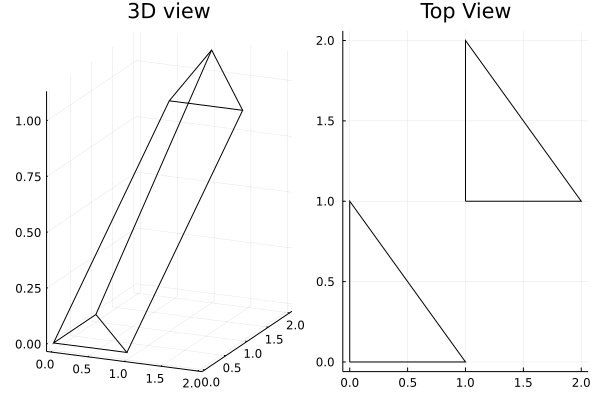

In [18]:
# unstructured element
coord_E = [0. 0. 0.;1. 0. 0.;0. 1. 0.;1. 1. 1.;2. 1. 1.;1. 2. 1.1]
PlotElem(coord_E)

In [19]:
TestNormalTrace(coord_E)

TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-0.002524086499835845, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(0.00011431282364147514, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-0.0021418164323533974, 0.0; atol = 1.0e-14)


TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-4.284541716294277e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-0.0010937389063185152, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(8.413621666117843e-5, 0.0; atol = 1.0e-14)
St

   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-0.0001379762854117897, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-0.0001631119347997869, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Mai

   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(1.221794096997286e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-1.3168740095180331e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:20 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:20
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-6.224513976969509e-6, 0.

TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(9.904155521488133e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(9.47293918895882e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-2.9135852489585943e-5, 0.0; atol = 1.0e-14)
Stac

Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(0.0041554249372350105, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(0.0033551492179039713, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src

   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(2.708917256176506e-6, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(1.9602337116034022e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main .

   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-7.809364010173718e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(4.6817718223046645e-6, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-2.2477301840954055e-7, 0

TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(4.9794706036536884e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(-1.1367011860208692e-5, 0.0; atol = 1.0e-14)
Stacktrace:
 [1] macro expansion
   @ ./In[14]:28 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] TestNormalTrace(coord_E::Matrix{Float64})
   @ Main ./In[14]:5
TestNormalTrace: Test Failed at In[14]:28
  Expression: isapprox(trace[i, j], 0.0; atol = err)
   Evaluated: isapprox(1.1515303254983063e-5, 0.0; atol = 1.0e-14)
S

LoadError: [91mSome tests did not pass: 342 passed, 144 failed, 0 errored, 0 broken.[39m